In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d
import cmasher

def create_population_voltage_matrix(spike_times_dict, t_start=None, t_end=None, dt=0.1, sigma=10):
    """
    Create a matrix of smoothed voltage traces from multiple neurons' spike times.
    
    Parameters:
    -----------
    spike_times_dict : dict
        Dictionary with neuron IDs as keys and spike time arrays as values
    t_start : float, optional
        Start time for the simulation (default: min spike time)
    t_end : float, optional
        End time for the simulation (default: max spike time)
    dt : float
        Time step for discretization in milliseconds
    sigma : float
        Standard deviation of the Gaussian kernel in milliseconds
        
    Returns:
    --------
    time : ndarray
        Time points
    voltage_matrix : ndarray
        Matrix of shape (n_neurons, n_timepoints) containing smoothed voltage traces
    neuron_ids : list
        List of neuron IDs in the same order as rows in voltage_matrix
    """
    # Determine time bounds if not provided
    all_spikes = np.concatenate([spikes for spikes in spike_times_dict.values() if len(spikes) > 0])
    t_start = t_start if t_start is not None else np.floor(np.min(all_spikes))
    t_end = t_end if t_end is not None else np.ceil(np.max(all_spikes))
    
    # Create time array
    time = np.arange(t_start, t_end, dt)
    
    # Convert sigma from ms to array indices
    sigma_idx = sigma / dt
    
    # Initialize voltage matrix
    neuron_ids = list(spike_times_dict.keys())
    voltage_matrix = np.zeros((len(neuron_ids), len(time)))
    
    # Create voltage trace for each neuron
    for i, nid in enumerate(neuron_ids):
        spike_times = spike_times_dict[nid]
        if len(spike_times) > 0:  # Skip empty spike trains
            # Create binary spike train
            spike_train = np.zeros_like(time)
            spike_indices = np.searchsorted(time, spike_times)
            valid_indices = (spike_indices >= 0) & (spike_indices < len(time))
            spike_train[spike_indices[valid_indices]] = 1
            
            # Apply Gaussian smoothing
            voltage_matrix[i] = gaussian_filter1d(spike_train, sigma_idx)
    
    # Normalize each neuron's trace to [0,1] range
    max_vals = np.maximum(np.max(voltage_matrix, axis=1, keepdims=True), 1e-10)
    voltage_matrix = voltage_matrix / max_vals
    
    return time, voltage_matrix, neuron_ids


In [2]:
# Load the simulation data. Created with https://github.com/KaliLab/ca3net

data = np.load('simulation_data/spike_trains_0.5_linear.npz')
LFP = pickle.load(open('simulation_data/LFP_12345.pkl', 'rb'))
replay = pickle.load(open('simulation_data/replay_12345.pkl', 'rb'))

# PC spikes
PC = pickle.load(open('simulation_data/PC_spikes_12345.pkl', 'rb'))
PC_spikes = [PC['spike_times'][PC['spiking_neurons'] == k] for k in np.unique(PC['spiking_neurons'])]

# BC spikes (inhibitory)
BC=pickle.load(open('simulation_data/BC_spikes_12345.pkl', 'rb'))
BC_spikes = [BC['spike_times'][BC['spiking_neurons'] == k] for k in np.unique(BC['spiking_neurons'])]

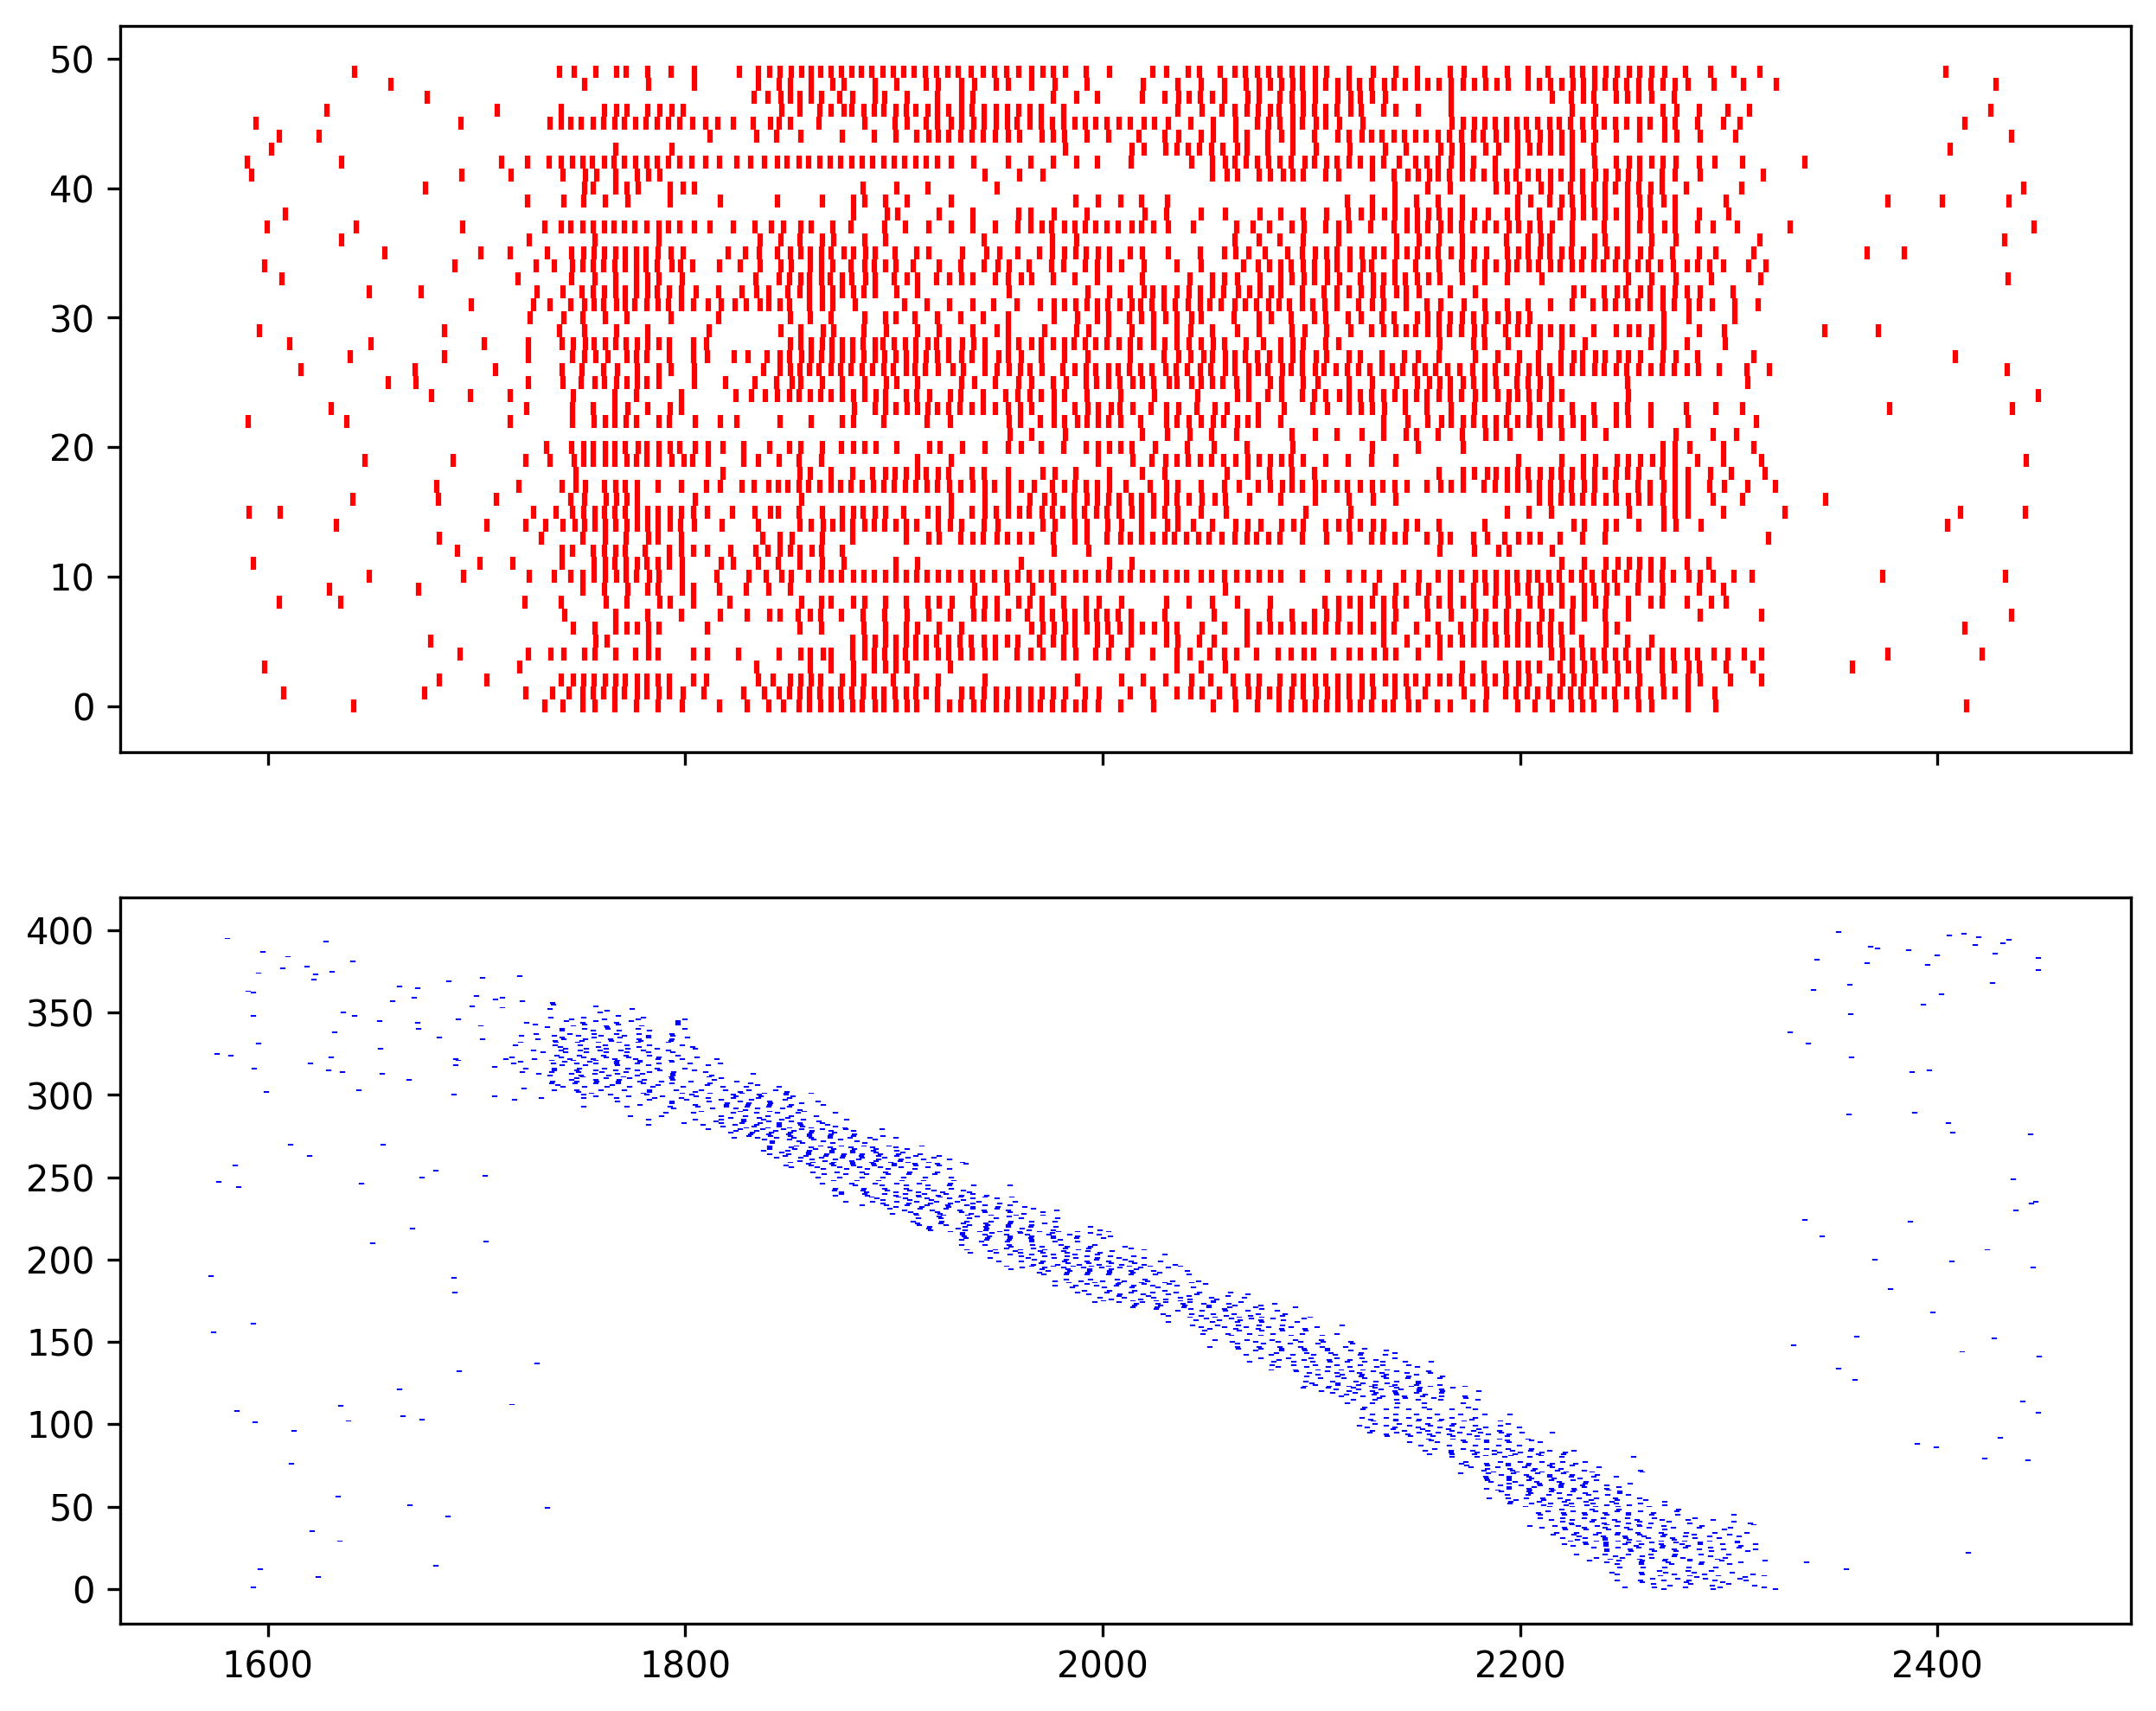

In [3]:

# --- Selecting one example SWR event
bounds = list(replay['replay_results'].keys())[1]
offset = 150 # 150 ms before and after the event 
replay_start, replay_end = bounds[0] - offset, bounds[1] + offset


# --- Filtering spikes that occur within the replay event
PC_spikes_filtered = [spike[spike > replay_start] for spike in PC_spikes]
PC_spikes_filtered = [spike[spike < replay_end] for spike in PC_spikes_filtered]
BC_spikes_filtered = [spike[spike > replay_start] for spike in BC_spikes]
BC_spikes_filtered = [spike[spike < replay_end] for spike in BC_spikes_filtered]

# --- Selecting neurons that are active during the replay event
PC_active = np.array([k for k in range(len(PC_spikes_filtered)) if len(PC_spikes_filtered[k]) > 0])
BC_active = np.array([k for k in range(len(BC_spikes_filtered)) if len(BC_spikes_filtered[k]) > 0])

np.random.seed(42)

selected_neurons_PC = PC_active[sorted(np.random.choice(np.arange(len(PC_active)), 400, replace=False))]
selected_neurons_BC = BC_active[sorted(np.random.choice(np.arange(len(BC_active)), 50, replace=False))]

selected_spikes_PC = {k: PC_spikes_filtered[k] for k in selected_neurons_PC}
selected_spikes_BC = {k: BC_spikes_filtered[k] for k in selected_neurons_BC}

fig, axs = plt.subplots(2,1, figsize=(10,8),dpi=300, sharex=True)
axs[0].eventplot(selected_spikes_BC.values(), color='r')
axs[1].eventplot(selected_spikes_PC.values(), color='b')


# --- Putting all selected spikes in one dictionary
selected_spikes = {f'PC_{k}': selected_spikes_PC[k] for k in selected_neurons_PC}
selected_spikes.update({f'BC_{k}': selected_spikes_BC[k] for k in selected_neurons_BC})

In [160]:
fake_graph = nx.watts_strogatz_graph(
    len(selected_neurons_BC) + len(selected_neurons_PC),
    p=0.15,
    k=20
)

# For each node in the graph, compute the degree and assign nodes with highest degree to inhibitory neurons
degrees = dict(fake_graph.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
inhibitory_nodes = [node for node, _ in sorted_degrees[:len(selected_neurons_BC)]]
neuron_types = {node: 'BC' if node in inhibitory_nodes else 'PC' for node in fake_graph.nodes()}
nx.set_node_attributes(fake_graph, neuron_types, 'cell_type')

# Set node names to neuron IDs
node_names = {i: f'PC_{k}' for i, k in enumerate(selected_neurons_PC)}
node_names.update({i + len(selected_neurons_PC): f'BC_{k}' for i, k in enumerate(selected_neurons_BC)})
fake_graph = nx.relabel_nodes(fake_graph, node_names)

# --- Create voltage traces
time, voltages_PC, _ = create_population_voltage_matrix(selected_spikes_PC, t_start=replay_start, t_end=replay_end, dt=0.25, sigma=0.5)
time, voltages_BC, _ = create_population_voltage_matrix(selected_spikes_BC, t_start=replay_start, t_end=replay_end, dt=0.25, sigma=0.5)

In [165]:
def create_animation(graph, pos, cell_type, voltages, filename_prefix):
    """
    Create animation and matte layer for a specific cell type
    
    Parameters:
    -----------
    graph : networkx.Graph
        The network graph
    pos : dict
        Node positions
    cell_type : str
        'PC' or 'BC'
    voltages : numpy.ndarray
        Voltage data for the specific cell type
    filename_prefix : str
        Prefix for output files
    """
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    
    # Get nodes for specific cell type
    nodelist = [node for node, attr in graph.nodes(data=True) if attr['cell_type'] == cell_type]
    
    # Set node shape based on cell type
    node_shape = '^' if cell_type == 'PC' else 'o'
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(graph, pos, 
                                 nodelist=nodelist,
                                 node_color='white',  # initial color
                                 node_size=10,
                                 ax=ax,
                                 node_shape=node_shape)
    
    # Set colormap (black to white)
    nodes.set_cmap(plt.cm.binary_r)
    nodes.set_norm(plt.Normalize(0, 1))
    

    # Save matte
    plt.savefig(f'{filename_prefix}_{cell_type}_matte.png')
    print(f'Saved matte for {cell_type}')

    # Animation update function
    def update(frame):
        nodes.set_array(voltages[:, frame])
        return nodes,
    
    # Create and save animation
    ani = FuncAnimation(fig, update,
                       frames=tqdm(np.arange(voltages.shape[1])[::5]),
                       blit=True,
                       interval=30)
    ani.save(f'{filename_prefix}_{cell_type}.mp4')
    plt.close()

In [166]:
output_prefix = 'network'
pos = nx.spring_layout(fake_graph, seed=42)

# Create PC animation and matte
create_animation(fake_graph, pos, 'PC', voltages_PC, output_prefix)

  0%|          | 0/704 [00:00<?, ?it/s]

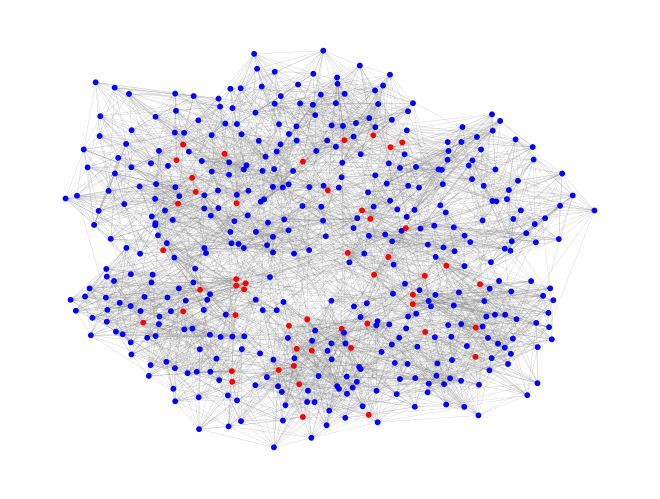

In [58]:
# Plot the graph with nodes colored by cell type
node_colors = {'PC': 'blue', 'BC': 'red'}
node_colors = [node_colors[fake_graph.nodes[node]['cell_type']] for node in fake_graph.nodes()]
pos = nx.spring_layout(fake_graph, seed=42)
nx.draw(fake_graph, pos, node_color=node_colors, with_labels=False, node_size=10, edge_color='gray',width=0.1)